#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project1 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project1/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
     - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# (Jupyter) 시각화 한글폰트 설정을 위해 아래 코드를 실행하세요.
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

In [3]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [4]:
# 주어진 데이터 셋을 불러오세요.(3개)
path = './data/'
train_df = pd.read_csv(path + 'data01_train.csv')
test_df = pd.read_csv(path + 'data01_test.csv')
feature = pd.read_csv(path + 'features.csv')

In [5]:
# 불필요한 칼럼을 삭제하세요.
train_df = train_df.drop(columns=['subject'])
test_df = test_df.drop(columns=['subject'])

#### 2) 기본 정보 조회

In [6]:
# 전체 데이터의 행, 열 개수를 확인
display(train_df.shape)
display(test_df.shape)
display(feature.shape)

(5881, 562)

(1471, 562)

(561, 4)

In [7]:
# 전체 데이터의 상위 5개 행 확인
display(train_df.head())
display(test_df.head())
display(feature.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


,sensor,agg,axis,feature_name
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z
3,tBodyAcc,std(),X,tBodyAcc-std()-X
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y


In [8]:
# 전체 데이터의 수치형 변수 분포 확인
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
summary = train_df[numeric_cols].describe().T
summary['skew'] = train_df[numeric_cols].skew()   # 왜도
summary['kurt'] = train_df[numeric_cols].kurt()   # 첨도
display(summary.head(10))

numeric_cols2 = test_df.select_dtypes(include=['int64', 'float64']).columns
summary2 = test_df[numeric_cols2].describe().T
summary2['skew'] = test_df[numeric_cols2].skew()   # 왜도
summary2['kurt'] = test_df[numeric_cols2].kurt()   # 첨도
display(summary2.head(10))

numeric_cols3 = feature.select_dtypes(include=['int64', 'float64']).columns
display(numeric_cols3)

,count,mean,std,min,25%,50%,75%,max,skew,kurt
tBodyAcc-mean()-X,5881.0,0.274811,0.067614,-0.503823,0.262919,0.277154,0.288526,1.000000,-1.992708,25.270158
tBodyAcc-mean()-Y,5881.0,-0.017799,0.039422,-0.684893,-0.024877,-0.017221,-0.010920,1.000000,2.020631,170.002842
tBodyAcc-mean()-Z,5881.0,-0.109396,0.058373,-1.000000,-0.121051,-0.108781,-0.098163,1.000000,1.709861,90.980485
tBodyAcc-std()-X,5881.0,-0.603138,0.448807,-1.000000,-0.992774,-0.943933,-0.242130,1.000000,0.666620,-0.880765
tBodyAcc-std()-Y,5881.0,-0.509815,0.501815,-0.999844,-0.977680,-0.844575,-0.034499,0.916238,0.401020,-1.448083
tBodyAcc-std()-Z,5881.0,-0.604058,0.417319,-0.999667,-0.980127,-0.856352,-0.262690,1.000000,0.676910,-0.645706
tBodyAcc-mad()-X,5881.0,-0.628151,0.424345,-1.000000,-0.993602,-0.948501,-0.291138,1.000000,0.717206,-0.708937
tBodyAcc-mad()-Y,5881.0,-0.525944,0.485115,-0.999419,-0.977865,-0.849266,-0.068857,0.967664,0.404094,-1.439999
tBodyAcc-mad()-Z,5881.0,-0.605374,0.413043,-1.000000,-0.980112,-0.849896,-0.268539,1.000000,0.638990,-0.770888
tBodyAcc-max()-X,5881.0,-0.465490,0.544995,-1.000000,-0.936067,-0.878729,-0.013690,1.000000,0.620688,-1.139105


,count,mean,std,min,25%,50%,75%,max,skew,kurt
tBodyAcc-mean()-X,1471.0,0.273198,0.079989,-1.000000,0.263787,0.277322,0.288058,0.631510,-6.866798,99.738427
tBodyAcc-mean()-Y,1471.0,-0.017281,0.045957,-1.000000,-0.024792,-0.017187,-0.010238,0.359587,-6.526640,168.931137
tBodyAcc-mean()-Z,1471.0,-0.108123,0.049082,-0.418354,-0.120733,-0.108124,-0.096606,0.543939,2.233829,34.031729
tBodyAcc-std()-X,1471.0,-0.614634,0.448480,-0.999717,-0.992669,-0.952426,-0.245405,0.899922,0.721920,-0.800044
tBodyAcc-std()-Y,1471.0,-0.515427,0.506094,-0.999873,-0.979082,-0.867309,-0.030639,0.782590,0.425783,-1.470720
tBodyAcc-std()-Z,1471.0,-0.607533,0.424243,-1.000000,-0.981070,-0.869890,-0.260223,0.931308,0.752295,-0.479046
tBodyAcc-mad()-X,1471.0,-0.639950,0.422994,-0.999867,-0.993498,-0.958705,-0.297260,0.950758,0.779584,-0.579333
tBodyAcc-mad()-Y,1471.0,-0.530760,0.489381,-1.000000,-0.979214,-0.873891,-0.058824,0.602458,0.416484,-1.498982
tBodyAcc-mad()-Z,1471.0,-0.609256,0.418536,-0.999879,-0.980659,-0.863451,-0.256657,0.784041,0.698525,-0.682319
tBodyAcc-max()-X,1471.0,-0.481055,0.542756,-0.948723,-0.936791,-0.890491,-0.030692,0.821218,0.670889,-1.091575


Index([], dtype='object')

In [9]:
# 전체 데이터의 모든 변수 확인
print('train_df')
for col in train_df.columns:
    print(col, train_df[col].dtype, train_df[col].isnull().sum())

print('\n\ntest_data')
for col in test_df.columns:
    print(col, test_df[col].dtype, test_df[col].isnull().sum())

train_df
tBodyAcc-mean()-X float64 0
tBodyAcc-mean()-Y float64 0
tBodyAcc-mean()-Z float64 0
tBodyAcc-std()-X float64 0
tBodyAcc-std()-Y float64 0
tBodyAcc-std()-Z float64 0
tBodyAcc-mad()-X float64 0
tBodyAcc-mad()-Y float64 0
tBodyAcc-mad()-Z float64 0
tBodyAcc-max()-X float64 0
tBodyAcc-max()-Y float64 0
tBodyAcc-max()-Z float64 0
tBodyAcc-min()-X float64 0
tBodyAcc-min()-Y float64 0
tBodyAcc-min()-Z float64 0
tBodyAcc-sma() float64 0
tBodyAcc-energy()-X float64 0
tBodyAcc-energy()-Y float64 0
tBodyAcc-energy()-Z float64 0
tBodyAcc-iqr()-X float64 0
tBodyAcc-iqr()-Y float64 0
tBodyAcc-iqr()-Z float64 0
tBodyAcc-entropy()-X float64 0
tBodyAcc-entropy()-Y float64 0
tBodyAcc-entropy()-Z float64 0
tBodyAcc-arCoeff()-X,1 float64 0
tBodyAcc-arCoeff()-X,2 float64 0
tBodyAcc-arCoeff()-X,3 float64 0
tBodyAcc-arCoeff()-X,4 float64 0
tBodyAcc-arCoeff()-Y,1 float64 0
tBodyAcc-arCoeff()-Y,2 float64 0
tBodyAcc-arCoeff()-Y,3 float64 0
tBodyAcc-arCoeff()-Y,4 float64 0
tBodyAcc-arCoeff()-Z,1 float64

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [10]:
# 데이터 분할을 합니다.
target = 'Activity'

# x, y 분리
X_train = train_df.drop(columns=target)
y_train = train_df[target]

X_test = test_df.drop(columns=target)
y_test  = test_df[target]

print("X_train shape:", X_train.shape)
print("y_train shape:", X_test.shape)

X_train shape: (5881, 561)
y_train shape: (1471, 561)


### (2) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [11]:
# 기존 레이블 저장
y_train_original = y_train.copy()
y_test_original  = y_test.copy()

In [12]:
# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()

y_train = le.fit_transform(y_train) 
y_test  = le.transform(y_test)

print("label", np.unique(y_train))

label [0 1 2 3 4 5]


### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [13]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("X_train shape:", X_train.shape)
print("X_val shape  :", X_val.shape)
print("\ny_train distribution:\n", pd.Series(y_train).value_counts())
print("\ny_val distribution:\n", pd.Series(y_val).value_counts())

X_train shape: (4704, 561)
X_val shape  : (1177, 561)

y_train distribution:
 0    892
2    869
1    826
3    798
5    686
4    633
Name: count, dtype: int64

y_val distribution:
 0    223
2    218
1    206
3    200
5    172
4    158
Name: count, dtype: int64


### (4) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [14]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - (옵션) 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1 : Hidden Layer 없이 모델 생성

In [15]:
# 모델 설계
clear_session()
model1 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(len(np.unique(y_train)), activation='softmax')
])

In [16]:
# 컴파일 및 학습
model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6431 - loss: 1.0378 - val_accuracy: 0.8003 - val_loss: 0.7581
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8516 - loss: 0.6418 - val_accuracy: 0.8250 - val_loss: 0.5803
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8818 - loss: 0.4986 - val_accuracy: 0.8836 - val_loss: 0.4595
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9018 - loss: 0.4163 - val_accuracy: 0.8938 - val_loss: 0.3980
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9128 - loss: 0.3615 - val_accuracy: 0.8980 - val_loss: 0.3539
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9182 - loss: 0.3216 - val_accuracy: 0.9006 - val_loss: 0.3263
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9222 - loss: 0.2938 - val_accuracy: 0.9150 - val_loss: 0.3006
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9305 - loss: 0.2686 - val_accuracy: 0.

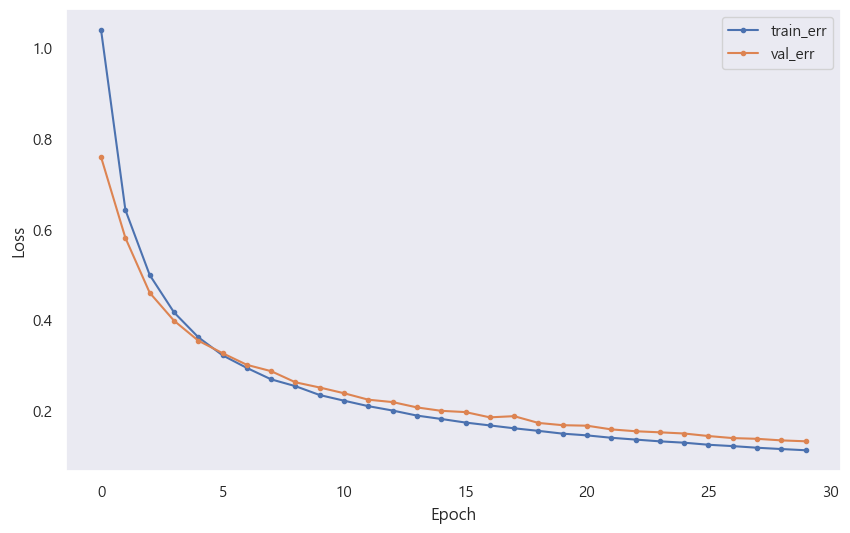

In [17]:
# 학습곡선
dl_history_plot(history1.history)

In [18]:
# 예측 및 평가
y_pred1 = model1.predict(X_test)  
y_pred_classes1 = y_pred1.argmax(axis=1) 

acc1 = accuracy_score(y_test, y_pred_classes1)
print(f"Accuracy Score: {acc1:.4f}")

print(classification_report(y_test, y_pred_classes1))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy Score: 0.9565
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       292
           1       0.89      0.89      0.89       254
           2       0.91      0.91      0.91       287
           3       0.99      0.98      0.98       228
           4       0.99      0.99      0.99       195
           5       0.97      0.99      0.98       215

    accuracy                           0.96      1471
   macro avg       0.96      0.96      0.96      1471
weighted avg       0.96      0.96      0.96      1471



In [19]:
#(옵션) 모델1번을 최소 5번 반복수행해서 얻은 성능의 평균값을 기록해보자!
def repeated_training_model1_simple(X_train, y_train, X_val, y_val, X_test, y_test, n_repeat=5):
    test_acc_list = []

    for _ in range(n_repeat):
        clear_session()
        model = Sequential([
            Input(shape=(X_train.shape[1],)),
            Dense(len(np.unique(y_train)), activation='softmax')
        ])
        model.compile(optimizer=Adam(0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=30, batch_size=32, verbose=0)


        test_pred = model.predict(X_test).argmax(axis=1)
        test_acc_list.append(accuracy_score(y_test, test_pred))

   
   
        mean_test, std_test = np.mean(test_acc_list), np.std(test_acc_list)
    return mean_test, std_test

In [20]:
# 사용 예시
mean_test, std_test = repeated_training_model1_simple(
    X_train, y_train, X_val, y_val, X_test, y_test, n_repeat=5
)

print(f"평균 정확도 : {mean_test:.4f}")
print(f"표준 편차   : {std_test:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
평균 정확도 : 0.9568
표준 편차   : 0.0024


### (2) 모델2 : 최소 5개 이상의 은닉층을 추가한 모델

In [21]:
# 모델 설계
clear_session()

model2 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

In [22]:
# 컴파일 및 학습
model2.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4779 - loss: 1.1063 - val_accuracy: 0.7392 - val_loss: 0.6171
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7457 - loss: 0.5607 - val_accuracy: 0.8445 - val_loss: 0.3655
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8503 - loss: 0.3666 - val_accuracy: 0.9031 - val_loss: 0.2440
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8858 - loss: 0.2734 - val_accuracy: 0.9295 - val_loss: 0.1986
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9196 - loss: 0.2165 - val_accuracy: 0.9448 - val_loss: 0.1430
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9267 - loss: 0.1832 - val_accuracy: 0.9482 - val_loss: 0.1448
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - loss: 0.1651 - val_accuracy: 0.9601 - val_loss: 0.1080
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9460 - loss: 0.1509 - val_accu

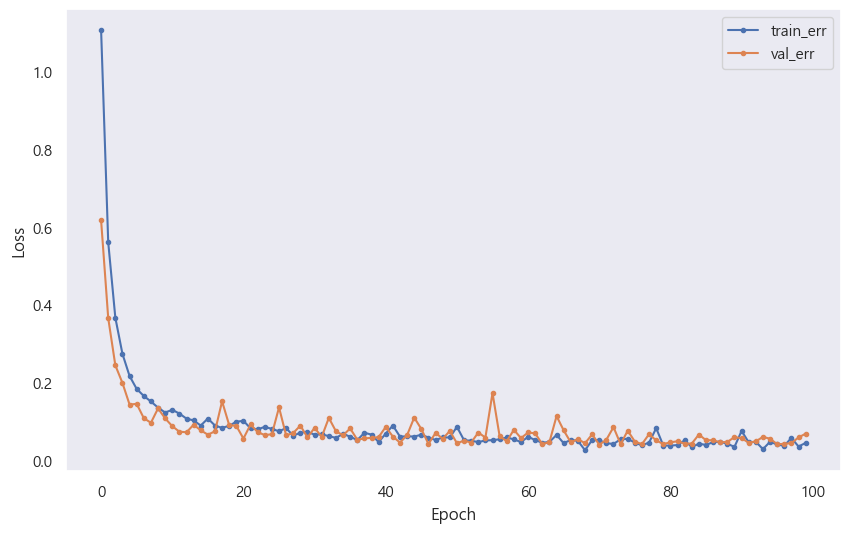

In [23]:
# 학습곡선
dl_history_plot(history2.history)


In [24]:
# 예측 및 평가
y_pred2 = model2.predict(X_test)  
y_pred_classes2 = y_pred2.argmax(axis=1) 

acc2 = accuracy_score(y_test, y_pred_classes2)
print(f"Accuracy Score: {acc2:.4f}")

print(classification_report(y_test, y_pred_classes2))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy Score: 0.9810
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       292
           1       0.94      0.96      0.95       254
           2       0.99      0.94      0.96       287
           3       1.00      1.00      1.00       228
           4       1.00      1.00      1.00       195
           5       1.00      1.00      1.00       215

    accuracy                           0.98      1471
   macro avg       0.98      0.98      0.98      1471
weighted avg       0.98      0.98      0.98      1471



### (3) 모델3 : 학습률, epoch 등 조정

In [25]:
# 모델 설계
clear_session()

model3 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

In [26]:
# 컴파일 및 학습
model3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5631 - loss: 0.9497 - val_accuracy: 0.8122 - val_loss: 0.4547
Epoch 2/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8289 - loss: 0.4136 - val_accuracy: 0.9091 - val_loss: 0.2490
Epoch 3/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8912 - loss: 0.2813 - val_accuracy: 0.9176 - val_loss: 0.2027
Epoch 4/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9062 - loss: 0.2504 - val_accuracy: 0.9346 - val_loss: 0.1769
Epoch 5/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9269 - loss: 0.1992 - val_accuracy: 0.9541 - val_loss: 0.1269
Epoch 6/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9311 - loss: 0.1767 - val_accuracy: 0.9541 - val_loss: 0.1389
Epoch 7/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9384 - loss: 0.1628 - val_accuracy: 0.9558 - val_loss: 0.1247
Epoch 8/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9362 - loss: 0.1712 - val_accu

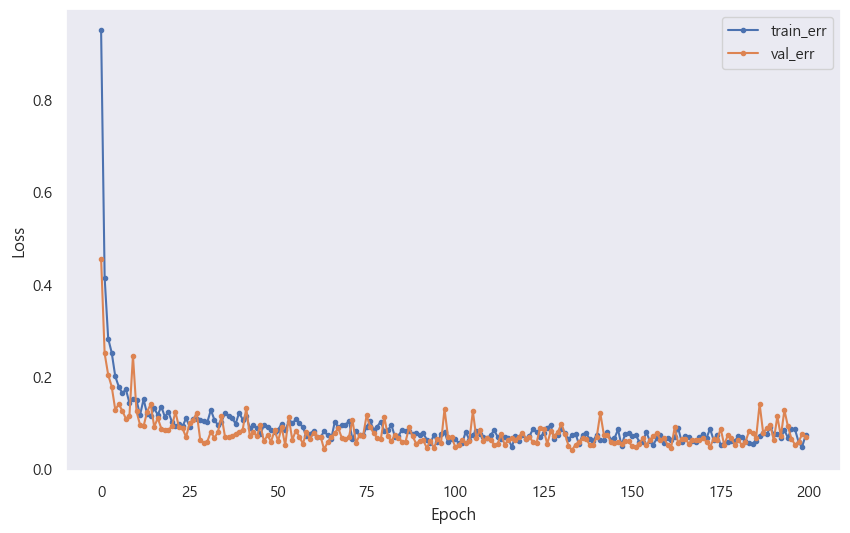

In [27]:
# 학습곡선
dl_history_plot(history3.history)

In [28]:
# 예측 및 평가
y_pred3 = model3.predict(X_test)  
y_pred_classes3 = y_pred3.argmax(axis=1) 

acc3 = accuracy_score(y_test, y_pred_classes3)
print(f"Accuracy Score: {acc3:.4f}")

print(classification_report(y_test, y_pred_classes3))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy Score: 0.9748
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.95      0.96      0.95       254
           2       0.96      0.95      0.96       287
           3       1.00      1.00      1.00       228
           4       1.00      0.95      0.97       195
           5       0.95      1.00      0.97       215

    accuracy                           0.97      1471
   macro avg       0.98      0.97      0.97      1471
weighted avg       0.98      0.97      0.97      1471



### (4) 모델4 :  학습률, epoch 등 조정

In [29]:
# 모델 설계
clear_session()

model4 = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

In [30]:
# 컴파일 및 학습
model4.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history4 = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1
)

Epoch 1/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2963 - loss: 1.5343 - val_accuracy: 0.3934 - val_loss: 1.1536
Epoch 2/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4256 - loss: 1.1203 - val_accuracy: 0.7256 - val_loss: 0.9438
Epoch 3/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5665 - loss: 0.9304 - val_accuracy: 0.7850 - val_loss: 0.6764
Epoch 4/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6792 - loss: 0.7127 - val_accuracy: 0.8131 - val_loss: 0.5176
Epoch 5/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7574 - loss: 0.5781 - val_accuracy: 0.8488 - val_loss: 0.4042
Epoch 6/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8053 - loss: 0.4736 - val_accuracy: 0.8496 - val_loss: 0.3510
Epoch 7/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8338 - loss: 0.4093 - val_accuracy: 0.8862 - val_loss: 0.2837
Epoch 8/200
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8582 - loss: 0.3521 - val_accu

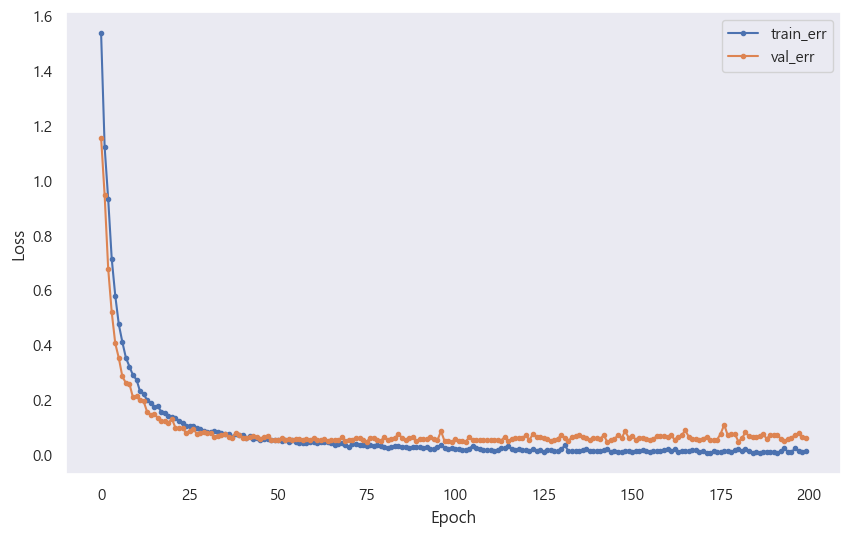

In [31]:
# 학습곡선
dl_history_plot(history4.history)

In [32]:
# 예측 및 평가
y_pred4 = model4.predict(X_test)  
y_pred_classes4 = y_pred4.argmax(axis=1) 

acc4 = accuracy_score(y_test, y_pred_classes4)
print(f"Accuracy Score: {acc4:.4f}")

print(classification_report(y_test, y_pred_classes4))

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy Score: 0.9871
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       292
           1       0.96      0.96      0.96       254
           2       0.97      0.97      0.97       287
           3       1.00      1.00      1.00       228
           4       1.00      1.00      1.00       195
           5       1.00      1.00      1.00       215

    accuracy                           0.99      1471
   macro avg       0.99      0.99      0.99      1471
weighted avg       0.99      0.99      0.99      1471



## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [33]:
#전체 데이터 불러오기(test)
test_df = pd.read_csv(path + 'data01_test.csv')

# subject 삭제
test_df = test_df.drop(columns=['subject'])

# x, y 분할
X_test = test_df.drop(columns=target)
y_test  = test_df[target]

# y : 정수인코딩 적용
y_test  = le.transform(y_test)

# x : 스케일링 적용
X_test = scaler.transform(X_test)

In [34]:
# test 데이터에 대한 성능 측정
models = [model1, model2, model3, model4]
model_names = ['model1', 'model2', 'model3', 'model4']

results = []

for m, name in zip(models, model_names):
    y_pred = m.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)

    acc = accuracy_score(y_test, y_pred_classes)
    results.append((name, acc))

print("=== Test 데이터 성능 ===")
for name, acc in results:
    print(f"{name} 정확도 : {acc:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
=== Test 데이터 성능 ===
model1 정확도 : 0.9565
model2 정확도 : 0.9810
model3 정확도 : 0.9748
model4 정확도 : 0.9871


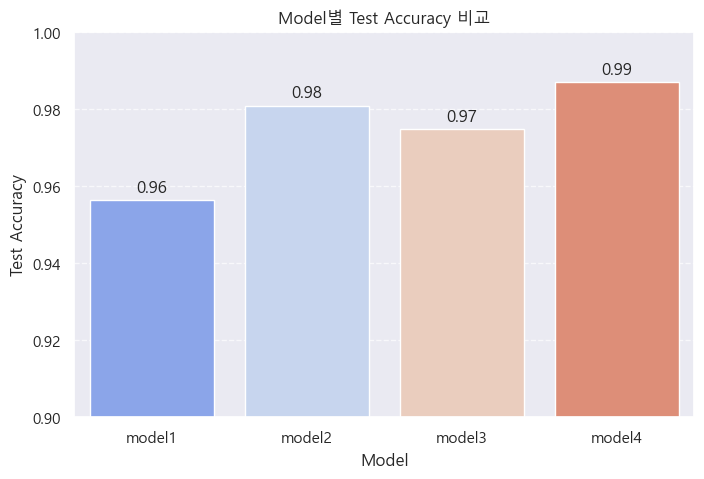

In [35]:
result_df = pd.DataFrame({
    'Model': [name for name, _ in results],
    'Test Accuracy': [acc for _, acc in results],
})


plt.figure(figsize=(8,5))
ax = sns.barplot(data=result_df, x='Model', y='Test Accuracy', palette='coolwarm')
plt.title('Model별 Test Accuracy 비교')
plt.ylim(0.9, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        x=p.get_x() + p.get_width() / 2, 
        y=height + 0.002,  # 막대 위에 약간 띄워서 표시
        s=f"{height:.2f}", 
        ha='center'
    )

plt.show()

#### 고생하셨습니다! 이제 단계적 모델링을 해봅시다.